# Compressed Sensing and Sparse Signal Recovery

In this notebook, we explore the concept of compressed sensing, a technique used in signal processing to recover sparse signals from a reduced number of measurements. This approach is incredibly useful in scenarios where acquiring full signal data is costly or impractical.

For our study case we create a signal with 1000 data, then we use compressed sensing to decrease this size to 461. Which is half the size of original matrix, and it should be noted that we use a double of factor of safety in selection of number of measurements, which is explained below. In other words it is even possible to create more compressed dataset that can be used later ot reconstruct the original signal.

We'll start by setting up our environment and initializing our parameters for the experiment.


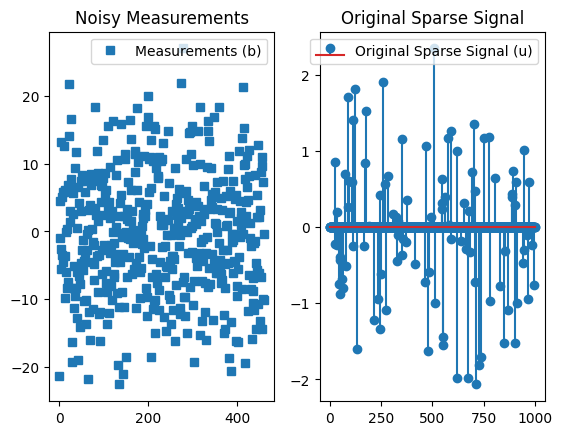

In [49]:
import numpy as np
import scipy.sparse as sp
import cvxpy as cvx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Initialization
N = 1000  # Total number of components in our vector
s = 100   # Sparsity level of the vector (number of non-zero elements)
m = int(np.ceil(2 * s * np.log(N/s)))  # Number of measurements

# Generating a random Gaussian measurement matrix
A = np.random.randn(m, N)

# Creating a sparse vector 'u' with 's' non-zero entries
u = sp.random(N, 1, density=0.1, data_rvs=np.random.randn).toarray()

# Generating noisy measurements 'b'
b = A @ u + 0.05 * np.random.randn(m, 1)  # '@' denotes matrix multiplication in Python

# Let's visualize our measurements and original sparse vector for reference
plt.subplot(1, 2, 1)
plt.plot(b, 's', label='Measurements (b)')
plt.title("Noisy Measurements")
plt.legend()

plt.subplot(1, 2, 2)
plt.stem(u, 'o', label='Original Sparse Signal (u)')
plt.title("Original Sparse Signal")
plt.legend()
plt.show()

# Explanation about the above plots can be added here


## Understanding the Setup

In the above code, we initialize our experiment by setting up three key parameters: `N`, `s`, and `m`. Here's what they represent:


1. **Definition of Parameters**:
   - $ N = 1000 $: Represents the total number of components in the vector. Mathematically, this defines the dimensionality of the vector space we're working in.
   - $ s = 100 $: Specifies the sparsity level of the vector, indicating the number of non-zero elements it contains.
   - $ m = \lceil 2 \cdot s \cdot \log(\frac{N}{s}) \rceil $: This formula calculates the number of measurements needed. It's derived from compressed sensing theory, ensuring that the number of measurements is sufficient to recover a sparse signal of sparsity $ s $ in a space of dimension $ N $.

2. **Measurement Matrix (A)**:
   - $ A \in \mathbb{R}^{m \times N} $: The measurement matrix $ A $ is a $ m \times N $ matrix with entries drawn from a normal distribution. In the code, `np.random.randn(m, N)` generates this matrix.

3. **Sparse Vector (u)**:
   - $ u \in \mathbb{R}^N $: The sparse vector $ u $ is a vector in $ N $-dimensional space with approximately $ s $ non-zero entries. The sparsity is achieved by setting a density of 0.1, which means about 10% of the entries are non-zero. This is represented in the code as `sp.random(N, 1, density=0.1, data_rvs=np.random.randn).toarray()`.

4. **Noisy Measurements (b)**:
   - $ b = A \cdot u + \text{noise} $: The measurements vector $ b $ is obtained by multiplying the matrix $ A $ with the sparse vector $ u $ and adding Gaussian noise. Mathematically, this is represented as $ b \in \mathbb{R}^m $, where $ b = A \cdot u + \epsilon $ and $ \epsilon $ is a noise vector with entries drawn from a normal distribution with a standard deviation of 0.05 (as indicated by `0.05 * np.random.randn(m, 1)` in the code).

In summary, the mathematical representation of this setup provides a clear view of how compressed sensing operates: a high-dimensional sparse signal $ u $ is linearly transformed into a lower-dimensional space through $ A $ to produce $ b $, with some added noise. The challenge, then, is to recover $ u $ from $ b $ given $ A $ and knowledge of the sparsity $ s $.



# Signal Recovery using Convex Optimization

Now, we move to the most crucial part of our experiment: recovering the original sparse signal from the compressed measurements. We'll use a convex optimization technique, specifically Quadratic Basis Pursuit, to recover our sparse signal. This involves minimizing the L1 norm of our reconstructed signal under the constraint that it should not deviate too much from our noisy measurements.


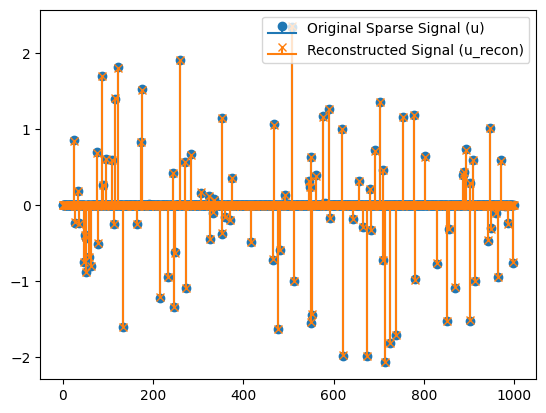

In [56]:
# Tolerance for the minimization (controls the fidelity to the measurements)
eta = 0.1

# Setting up the optimization problem
u_recon = cvx.Variable(N)
objective = cvx.Minimize(cvx.norm(u_recon, 1))
constraints = [cvx.norm(A @ u_recon - b.ravel(), 2) <= eta]
prob = cvx.Problem(objective, constraints)
prob.solve()


# Visualizing both the original and reconstructed signals for comparison


plt.stem(u, linefmt='C0-', markerfmt='C0o', basefmt='C0-', label='Original Sparse Signal (u)')
plt.stem(u_recon.value, linefmt='C1-', markerfmt='C1x', basefmt='C1-', label='Reconstructed Signal (u_recon)')
plt.title("Original and Reconstructed Sparse Signal")
plt.legend()

plt.show()




## Understanding the Reconstruction

In this section, we set up and solve a convex optimization problem. The `cvx.Variable(N)` creates a variable for our reconstructed signal `u_recon`. Our objective is to minimize the L1 norm of `u_recon`, promoting sparsity. The constraint ensures that our reconstructed signal, when passed through the same measurement process (multiplied by `A`), remains close to the original measurements `b`. This closeness is controlled by `eta`, the tolerance parameter.

The reconstructed signal `u_recon` is then plotted, allowing us to visually compare it to our original sparse signal `u`. Through this process, we observe the effectiveness of compressed sensing in recovering sparse signals from a limited number of measurements.


### A note on optimization steps:

1. **Definition of Reconstruction Variable (`u_recon`)**:
   - $ \mathbf{u_{recon}} \in \mathbb{R}^N $: This represents the variable for the reconstructed signal. In the optimization context, $ \mathbf{u_{recon}} $ is the vector we are trying to solve for, which should approximate the original sparse signal $ \mathbf{u} $.

2. **Objective Function**:
   - **Minimize $ \lVert \mathbf{u_{recon}} \rVert_1 $**: The objective of the optimization problem is to minimize the L1 norm (sum of absolute values) of the reconstructed signal. The L1 norm is used because it promotes sparsity in the solution. Mathematically, this is expressed as:
     $$ \text{minimize} \; \lVert \mathbf{u_{recon}} \rVert_1 $$

3. **Constraints**:
   - **Subject to $ \lVert A\mathbf{u_{recon}} - \mathbf{b} \rVert_2 \leq \eta $**: This constraint ensures that the reconstructed signal, when multiplied by the measurement matrix $ A $, is not too far from the noisy measurements $ \mathbf{b} $. The L2 norm (Euclidean norm) is used here to measure the closeness. The parameter $ \eta $ controls the tolerance for deviation from $ \mathbf{b} $. Mathematically, the constraint is:
     $$ \lVert A\mathbf{u_{recon}} - \mathbf{b} \rVert_2 \leq \eta $$

4. **Optimization Problem**:
   - The entire optimization problem can be summarized as:
     $$ \begin{aligned}
     & \text{minimize} \; \lVert \mathbf{u_{recon}} \rVert_1 \\
     & \text{subject to} \; \lVert A\mathbf{u_{recon}} - \mathbf{b} \rVert_2 \leq \eta
     \end{aligned} $$

In summary, this optimization setup aims to find a sparse vector $ \mathbf{u_{recon}} $ that is close to the original signal $ \mathbf{u} $ by ensuring that its transformation through $ A $ remains within a certain tolerance of the noisy measurements $ \mathbf{b} $, while also maintaining sparsity. This is a classic formulation in compressed sensing for sparse signal recovery.
